# DESeq with `bedtools multicov` on gene bed file

# DMGs for hypoxia and control treatments 
All the oysters included in this analysis have experienced hypoxia or control treatments for either phase 1 and/or phase 2. No other treatments (both, warm) are included in this analysis.


Counts matrix generated with `bedtools multicov` and CV_gene_sorted.bed

In [3]:
# loading required packages
library(tidyverse)
library(DESeq2)
library(EnhancedVolcano)
library(dplyr)
library(ggh4x)

In [17]:
countsGFF <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/genomic_feature_tracks/geneGFF_Multicov.csv', sep='\t', header = FALSE)

In [18]:
# pulling out just the gene name/LOC number
countsGFF <- countsGFF %>% mutate(LOC_number = str_extract(V9, "LOC\\d+"))

# setting the gene name/LOC number as the row name
rownames(countsGFF) = countsGFF$LOC_number

# selecting only sample columns with counts
countsGFF <- countsGFF[,10:29]


head(countsGFF)

,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
LOC111116054,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0
LOC111126949,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
LOC111110729,0,0,0,0,0,0,2,0,0,0,0,0,0,0,4,2,0,0,2,0
LOC111112434,8,12,0,0,6,4,0,0,2,2,2,1,0,0,4,0,6,0,0,10
LOC111120752,14,4,2,0,6,0,0,0,2,0,6,2,0,0,4,0,2,0,0,2
LOC111128944,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
# read BAM file names 
bam_files <- dir(path = "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_methyl_assembly/assembly_pipeline_files/BEDtools/working_BAM_sequences/", pattern = "^.*\\.bam$", full.names = FALSE, ignore.case = TRUE, all.files = TRUE)

# clean sample names
bam_files_clean <- gsub("^2018--|-CV_sorted\\.bam$", "", bam_files)
bam_files_clean

colnames(countsGFF) <- c(bam_files_clean)
head(countsGFF)

[1] "BBB-WBO-B21" "BBB-WBV-B70" "BBO-BBO-B16" "BBO-BBY-B27" "BBO-WBO-B16"
 [6] "BBO-WBV-B64" "BBR-BBB-B50" "BBR-BBG-B38" "BBR-BBY-B26" "BBY-WBG-B42"
[11] "WBB-WBV-W69" "WBG-BBB-W56" "WBG-WBG-W44" "WBO-BBR-W03" "WBO-WBV-W64"
[16] "WBR-BBY-W25" "WBV-WBO-W23" "WBV-WBR-W12" "WBY-BBV-W65" "WBY-BBY-W30"

,BBB-WBO-B21,BBB-WBV-B70,BBO-BBO-B16,BBO-BBY-B27,BBO-WBO-B16,BBO-WBV-B64,BBR-BBB-B50,BBR-BBG-B38,BBR-BBY-B26,BBY-WBG-B42,WBB-WBV-W69,WBG-BBB-W56,WBG-WBG-W44,WBO-BBR-W03,WBO-WBV-W64,WBR-BBY-W25,WBV-WBO-W23,WBV-WBR-W12,WBY-BBV-W65,WBY-BBY-W30
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
LOC111116054,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0
LOC111126949,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
LOC111110729,0,0,0,0,0,0,2,0,0,0,0,0,0,0,4,2,0,0,2,0
LOC111112434,8,12,0,0,6,4,0,0,2,2,2,1,0,0,4,0,6,0,0,10
LOC111120752,14,4,2,0,6,0,0,0,2,0,6,2,0,0,4,0,2,0,0,2
LOC111128944,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
meta <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/counts_and_meta/CV_CE18_meta.csv')

# changing rownames to the unique sample ID
rownames(meta) <- meta$unique_ID

meta$treatment <- paste(meta$Phase1, meta$Phase2, sep = "_")

# pulling out only the rows I need
meta <- select(meta, Phase1, Phase2, treatment)

meta <- meta[colnames(countsGFF),]
head(meta)

,Phase1,Phase2,treatment
,<chr>,<chr>,<chr>
BBB-WBO-B21,hypoxic,control,hypoxic_control
BBB-WBV-B70,hypoxic,control,hypoxic_control
BBO-BBO-B16,hypoxic,hypoxic,hypoxic_hypoxic
BBO-BBY-B27,hypoxic,hypoxic,hypoxic_hypoxic
BBO-WBO-B16,hypoxic,control,hypoxic_control
BBO-WBV-B64,hypoxic,control,hypoxic_control


In [23]:
# setting the same order for counts matrix and meta data
countsGFF <- countsGFF[,rownames(meta)]
all(rownames(meta) == colnames(countsGFF))

[1] TRUE

now ready for analysis

## Making *all* pairwise comparisons
we want to look at all pairwise comparisons, just to get the full picture..

these include:
- control control vs. hypoxic hypoxic
- hypoxic control vs. control hypoxic

In [24]:
# creating DESeq2 objext from the matrix, with the design = treatment (which has both phase 1 and phase 2 variables)
dds <- DESeqDataSetFromMatrix(countData = countsGFF,
                              colData = meta, 
                              design = ~ treatment)
dds=DESeq(dds)
resultsNames(dds)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



[1] "Intercept"                                   
[2] "treatment_control_hypoxic_vs_control_control"
[3] "treatment_hypoxic_control_vs_control_control"
[4] "treatment_hypoxic_hypoxic_vs_control_control"

### control control vs. hypoxic hypoxic
CC vs. HH

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895




out of 26176 with nonzero total read count
adjusted p-value < 0.1
LFC > 0.25 (up)    : 1, 0.0038%
LFC < -0.25 (down) : 1, 0.0038%
outliers [1]       : 528, 2%
low counts [2]     : 0, 0%
(mean count < 4)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



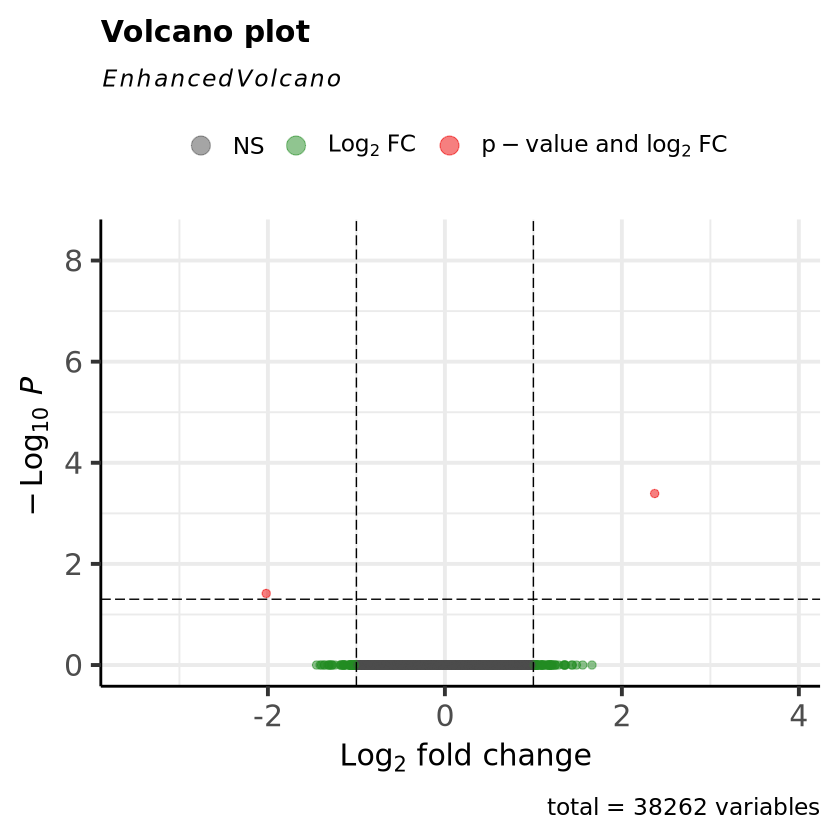

In [25]:
# control control vs. hypoxic hypoxic

contrast2 <- c("treatment", "hypoxic_hypoxic", "control_control")

# results of contrast1 with lfcThreshold=0.25 and normal shrinkage estimator
ls<-lfcShrink(dds, # dds object
                      contrast = contrast2, # only coef or contrast can be specified
                      type="normal", lfcThreshold=0.25,
                      cooksCutoff=FALSE, independentFiltering=FALSE) # adding stuff to change outliers/padj=NA
summary(ls)

EnhancedVolcano(ls, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

1 DMGs for control control

1 DMGs for hypoxic hypoxic

In [26]:
write.csv(ls, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/bedtools_geneGFF_DMGs/CC_HH.csv')

### hypoxic control vs. control control
HC vs. CC

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895




out of 26176 with nonzero total read count
adjusted p-value < 0.1
LFC > 0.25 (up)    : 3, 0.011%
LFC < -0.25 (down) : 22, 0.084%
outliers [1]       : 528, 2%
low counts [2]     : 12001, 46%
(mean count < 4)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



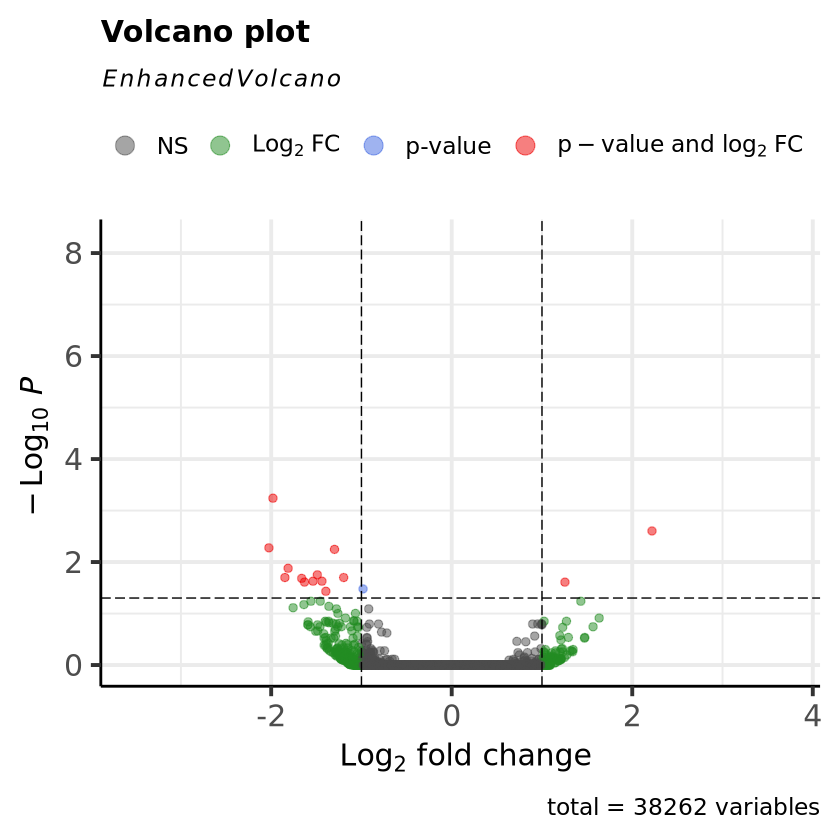

In [27]:
# hypoxic control vs. control control

contrast3 <- c("treatment", "hypoxic_control", "control_control")

# results of contrast1 with lfcThreshold=0.25 and normal shrinkage estimator
ls2<-lfcShrink(dds, # dds object
                      contrast = contrast3, # only coef or contrast can be specified
                      type="normal", lfcThreshold=0.25,
                      cooksCutoff=FALSE, independentFiltering=FALSE) # adding stuff to change outliers/padj=NA
summary(ls2)

EnhancedVolcano(ls2, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

3 DMGs for hypoxic control

22 DMGs for control control

In [28]:
write.csv(ls2, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/bedtools_geneGFF_DMGs/HC_CC.csv')

### control hypoxic vs. control control
CH vs. CC

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895




out of 26176 with nonzero total read count
adjusted p-value < 0.1
LFC > 0.25 (up)    : 1, 0.0038%
LFC < -0.25 (down) : 0, 0%
outliers [1]       : 528, 2%
low counts [2]     : 0, 0%
(mean count < 4)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



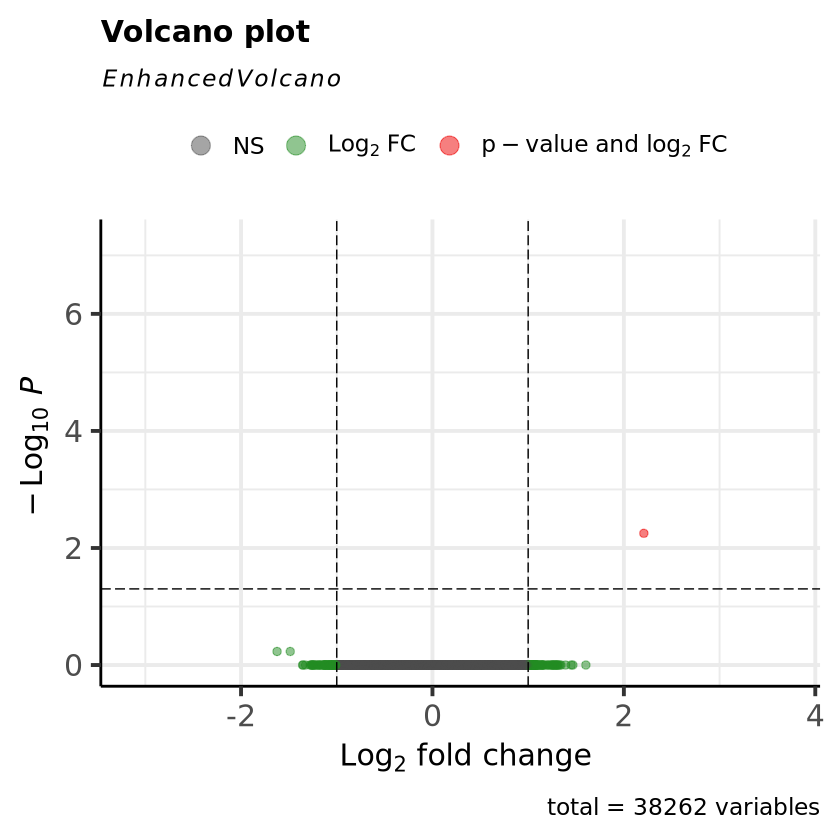

In [29]:
# control hypoxic vs. control control

contrast4 <- c("treatment", "control_hypoxic", "control_control")

# results of contrast1 with lfcThreshold=0.25 and normal shrinkage estimator
ls3<-lfcShrink(dds, # dds object
                      contrast = contrast4, # only coef or contrast can be specified
                      type="normal", lfcThreshold=0.25,
                      cooksCutoff=FALSE, independentFiltering=FALSE) # adding stuff to change outliers/padj=NA
summary(ls3)

EnhancedVolcano(ls3, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

1 DMGs for control hypoxic

0 DMGs for control control

In [30]:
write.csv(ls3, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/bedtools_geneGFF_DMGs/CC_CH.csv')

### hypoxic hypoxic vs. hypoxic control
HH vs. HC

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895




out of 26176 with nonzero total read count
adjusted p-value < 0.1
LFC > 0.25 (up)    : 97, 0.37%
LFC < -0.25 (down) : 15, 0.057%
outliers [1]       : 528, 2%
low counts [2]     : 12940, 49%
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



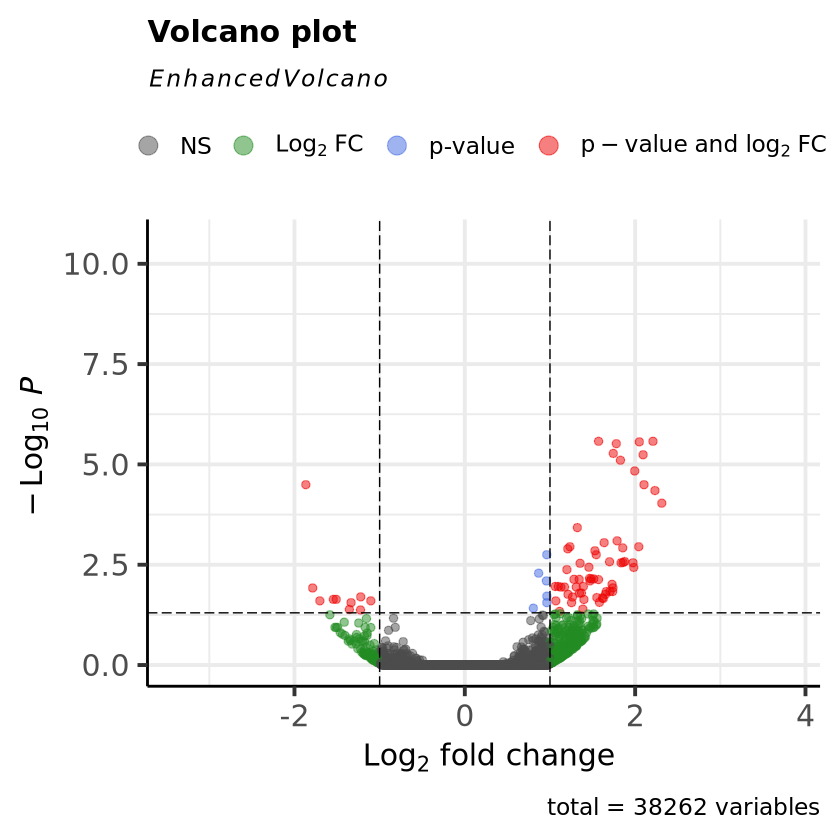

In [31]:
# hypoxic hypoxic vs. hypoxic control

contrast5 <- c("treatment", "hypoxic_hypoxic", "hypoxic_control")

# results of contrast1 with lfcThreshold=0.25 and normal shrinkage estimator
ls4<-lfcShrink(dds, # dds object
                      contrast = contrast5, # only coef or contrast can be specified
                      type="normal", lfcThreshold=0.25,
                      cooksCutoff=FALSE, independentFiltering=FALSE) # adding stuff to change outliers/padj=NA
summary(ls4)

EnhancedVolcano(ls4, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

97 DMGs for hypoxic hypoxic

15 DMGs for hypoxic control

In [32]:
write.csv(ls4, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/bedtools_geneGFF_DMGs/HC_HH.csv')

### hypoxic hypoxic vs. control hypoxic
HH vs. CH

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895




out of 26176 with nonzero total read count
adjusted p-value < 0.1
LFC > 0.25 (up)    : 0, 0%
LFC < -0.25 (down) : 0, 0%
outliers [1]       : 528, 2%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



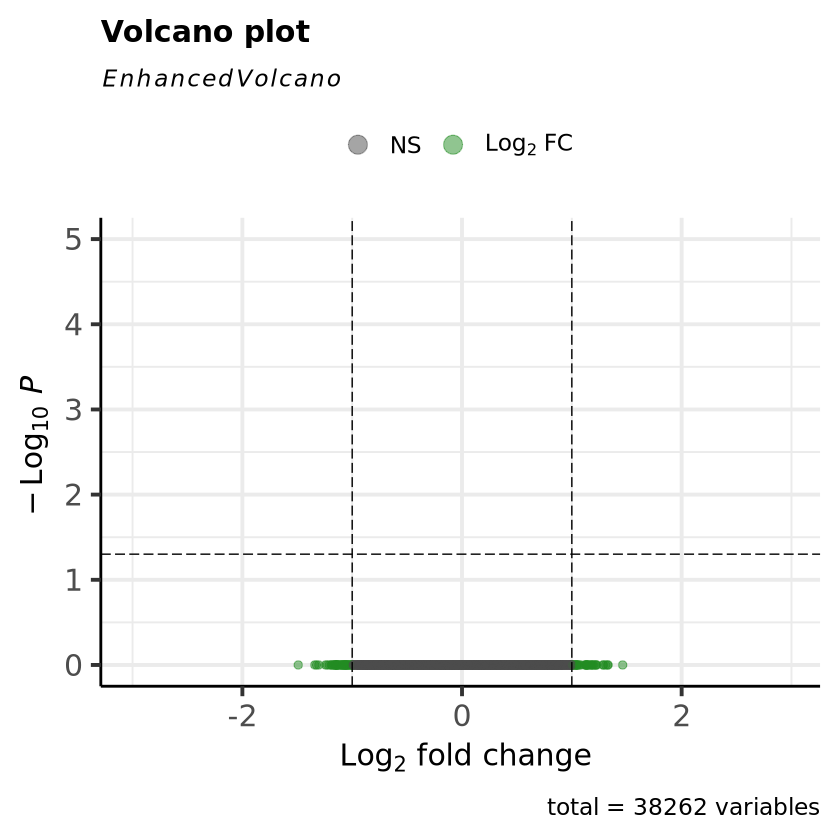

In [33]:
# hypoxic hypoxic vs. control hypoxic

contrast6 <- c("treatment", "hypoxic_hypoxic", "control_hypoxic")

# results of contrast1 with lfcThreshold=0.25 and normal shrinkage estimator
ls5<-lfcShrink(dds, # dds object
                      contrast = contrast6, # only coef or contrast can be specified
                      type="normal", lfcThreshold=0.25,
                      cooksCutoff=FALSE, independentFiltering=FALSE) # adding stuff to change outliers/padj=NA
summary(ls5)

EnhancedVolcano(ls5, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

0 DMGs for hypoxic hypoxic

0 DMGs for control hypoxic

In [48]:
write.csv(ls5, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/bedtools_geneGFF_DMGs/HH_HC.csv')

### hypoxic control vs. control hypoxic
HC vs. CH

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895




out of 26176 with nonzero total read count
adjusted p-value < 0.1
LFC > 0.25 (up)    : 86, 0.33%
LFC < -0.25 (down) : 185, 0.71%
outliers [1]       : 528, 2%
low counts [2]     : 11550, 44%
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



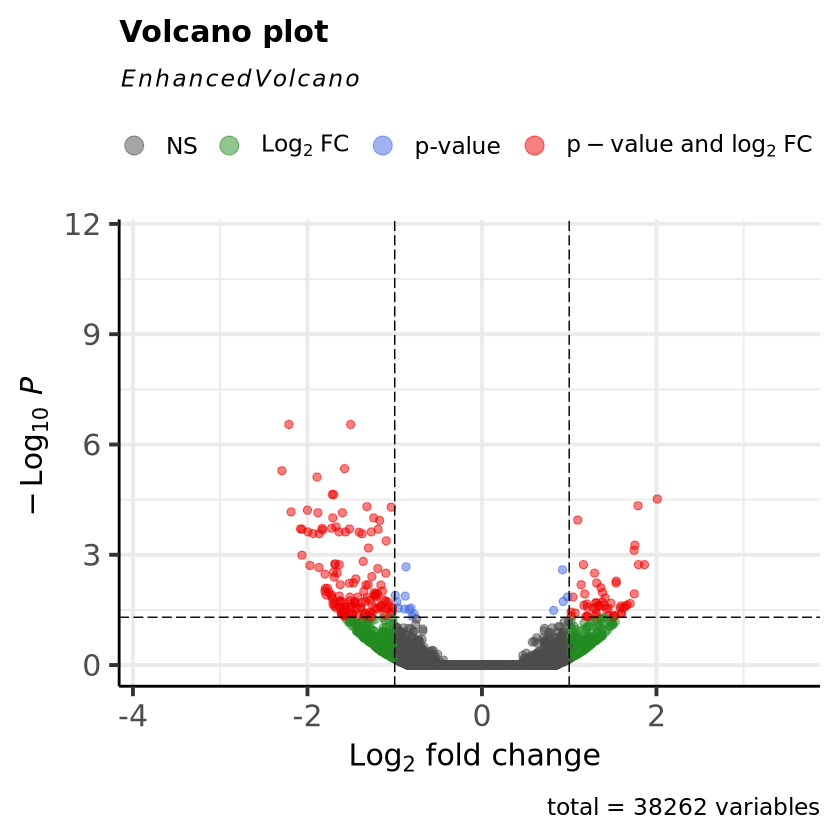

In [35]:
# hypoxic control vs. control hypoxic

contrast9 <- c("treatment", "hypoxic_control", "control_hypoxic")
# results of contrast1 with lfcThreshold=0.25 and normal shrinkage estimator
ls6<-lfcShrink(dds, # dds object
                      contrast = contrast9, # only coef or contrast can be specified
                      type="normal", lfcThreshold=0.25,
                      cooksCutoff=FALSE, independentFiltering=FALSE) # adding stuff to change outliers/padj=NA
summary(ls6)

EnhancedVolcano(ls6, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

86 DMGs for hypoxic control

183 DMGs for control hypoxic

so there is a difference in methylation for *when* you experience hypoxic stress

In [36]:
write.csv(ls6, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/bedtools_geneGFF_DMGs/HC_CH.csv')

### Phase 1 control vs. hypoxic
Cx vs. Hx

In [23]:
# creating DESeq2 objext from the matrix, with the design = treatment (which has both phase 1 and phase 2 variables)
p1_dds <- DESeqDataSetFromMatrix(countData = counts2,
                                 colData = meta,
                                 design = ~Phase1)
p1_dds=DESeq(p1_dds)
resultsNames(p1_dds)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 1085 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "Intercept"                 "Phase1_hypoxic_vs_control"

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895




out of 26096 with nonzero total read count
adjusted p-value < 0.1
LFC > 0.25 (up)    : 0, 0%
LFC < -0.25 (down) : 0, 0%
outliers [1]       : 1004, 3.8%
low counts [2]     : 79, 0.3%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



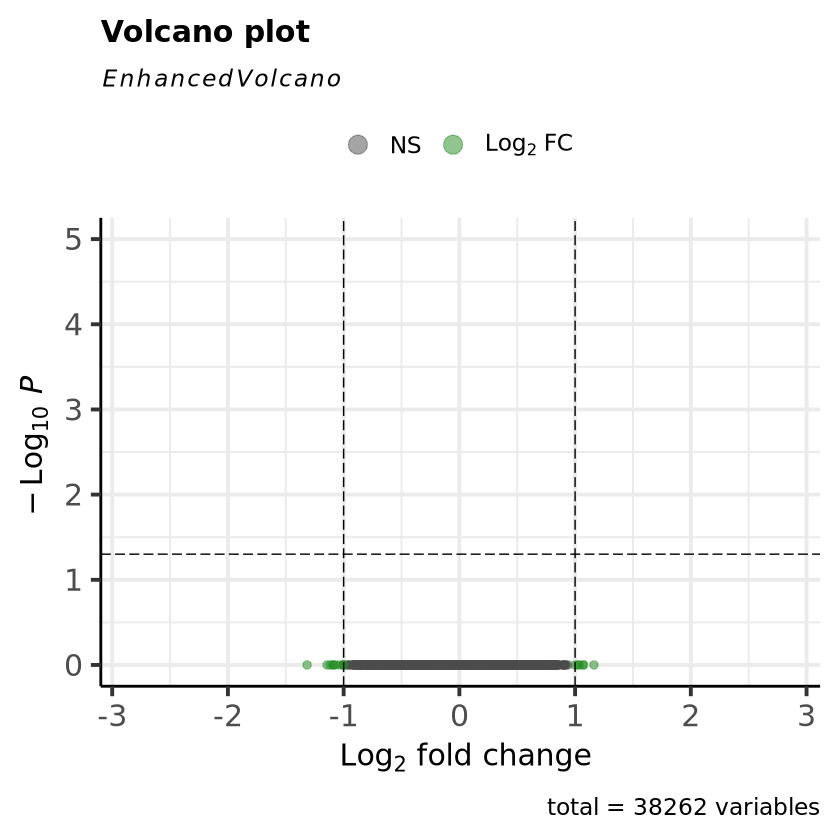

In [24]:
# phase 1 hypoxic vs. control

contrast7 <- c("Phase1", "hypoxic", "control")
# results of contrast1 with lfcThreshold=0.25 and normal shrinkage estimator
ls7<-lfcShrink(p1_dds, # dds object
                      contrast = contrast7, # only coef or contrast can be specified
                      type="normal", lfcThreshold=0.25,
                      cooksCutoff=FALSE, independentFiltering=FALSE) # adding stuff to change outliers/padj=NA
summary(ls7)

EnhancedVolcano(ls7, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

0 DMGs for phase 1 hypoxic

0 DMGs for phase 1 control

### Phase 2 control vs. hypoxic
xC vs. xH

In [26]:
# creating DESeq2 objext from the matrix, with the design = treatment (which has both phase 1 and phase 2 variables)
p2_dds <- DESeqDataSetFromMatrix(countData = counts2,
                              colData = meta, 
                              design = ~ Phase2)
p2_dds=DESeq(p2_dds)
resultsNames(p2_dds)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 1106 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "Intercept"                 "Phase2_hypoxic_vs_control"

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895




out of 26077 with nonzero total read count
adjusted p-value < 0.1
LFC > 0.25 (up)    : 7, 0.027%
LFC < -0.25 (down) : 1, 0.0038%
outliers [1]       : 1002, 3.8%
low counts [2]     : 98, 0.38%
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



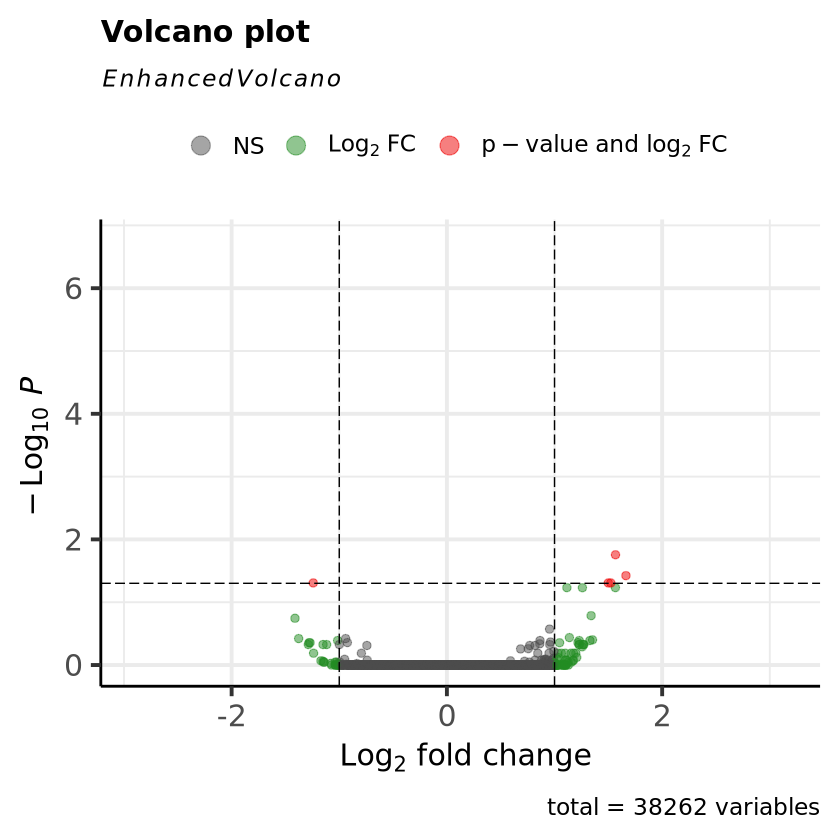

In [27]:
# phase 2 hypoxic vs. control

contrast8 <- c("Phase2", "hypoxic", "control")
# results of contrast1 with lfcThreshold=0.25 and normal shrinkage estimator
ls8<-lfcShrink(p2_dds, # dds object
                      contrast = contrast8, # only coef or contrast can be specified
                      type="normal", lfcThreshold=0.25,
                      cooksCutoff=FALSE, independentFiltering=FALSE) # adding stuff to change outliers/padj=NA
summary(ls8)

EnhancedVolcano(ls8, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

7 DMGs for phase 2 hypoxic

1 DMGs for phase 2 control

#### diff. setup of DESeq

In [45]:
# creating DESeq2 objext from the matrix, with the design = treatment (which has both phase 1 and phase 2 variables)
dds2 <- DESeqDataSetFromMatrix(countData = countsGFF,
                              colData = meta, 
                              design = ~ Phase1 + Phase2 + Phase1:Phase2)
dds2=DESeq(dds2)
resultsNames(dds2)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



[1] "Intercept"                   "Phase1_hypoxic_vs_control"  
[3] "Phase2_hypoxic_vs_control"   "Phase1hypoxic.Phase2hypoxic"

## NMDS Plot
using DESeq2 dds object (which used the argument design=~treatment)

In [28]:
# MDS plot

# normalization & transformation
vsd <- vst(dds)

# calculate sample distances
sample_dists <- assay(vsd) %>%
t() %>%
dist() %>%
as.matrix()

head(sample_dists)

# calculate MDS value from distance matrix
mdsData <- data.frame(cmdscale(sample_dists))
mds <- cbind(mdsData, as.data.frame(colData(vsd))) # combine with sample data
head(mds)

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



,BBB-WBO-B21,BBB-WBV-B70,BBO-BBO-B16,BBO-BBY-B27,BBO-WBO-B16,BBO-WBV-B64,BBR-BBB-B50,BBR-BBG-B38,BBR-BBY-B26,BBY-WBG-B42,WBB-WBV-W69,WBG-BBB-W56,WBG-WBG-W44,WBO-BBR-W03,WBO-WBV-W64,WBR-BBY-W25,WBV-WBO-W23,WBV-WBR-W12,WBY-BBV-W65,WBY-BBY-W30
BBB-WBO-B21,0.00000,42.48208,47.17116,47.43029,41.88670,41.33471,46.44429,44.48095,45.83202,42.94436,44.84007,50.38244,51.47129,56.30776,45.94733,50.74397,49.88377,55.05286,51.55617,50.02125
BBB-WBV-B70,42.48208,0.00000,42.45094,45.15634,41.79867,41.29880,41.58077,43.80955,43.07398,48.73965,44.16884,48.45587,50.91740,58.54745,44.14705,44.84179,48.74459,55.23852,49.83360,47.31499
BBO-BBO-B16,47.17116,42.45094,0.00000,41.92224,42.53414,46.54009,39.01824,40.72396,38.66893,49.54104,43.84471,42.01293,45.47848,59.31022,41.76046,44.15498,44.64558,49.88913,42.22189,41.02226
BBO-BBY-B27,47.43029,45.15634,41.92224,0.00000,45.63906,44.70446,41.98129,42.17007,36.91813,50.63517,44.58139,44.28793,47.76147,59.20383,43.99617,48.41355,47.58969,52.00297,42.50658,38.99214
BBO-WBO-B16,41.88670,41.79867,42.53414,45.63906,0.00000,42.26833,43.47704,44.87646,43.23636,47.07597,43.31220,47.78075,49.82820,58.24286,42.71086,48.68963,47.60154,51.68923,46.90474,46.70883
BBO-WBV-B64,41.33471,41.29880,46.54009,44.70446,42.26833,0.00000,45.86910,45.15776,42.51380,47.02522,40.35257,48.71679,49.29416,56.18609,44.72215,49.01259,50.02071,54.13786,50.34535,47.61053


,X1,X2,Phase1,Phase2,treatment,sizeFactor
,<dbl>,<dbl>,<chr>,<chr>,<fct>,<dbl>
BBB-WBO-B21,-15.073444,-16.314113,hypoxic,control,hypoxic_control,2.348079
BBB-WBV-B70,-6.204780,-12.283237,hypoxic,control,hypoxic_control,2.038944
BBO-BBO-B16,8.368919,1.051296,hypoxic,hypoxic,hypoxic_hypoxic,1.668247
BBO-BBY-B27,7.152727,3.421347,hypoxic,hypoxic,hypoxic_hypoxic,1.115797
BBO-WBO-B16,-5.358212,-11.323257,hypoxic,control,hypoxic_control,2.415633
BBO-WBV-B64,-11.906799,-10.387166,hypoxic,control,hypoxic_control,2.145171


In [29]:
mds$trmt <- ifelse(mds$treatment == 'hypoxic_control', 'HC',
                       ifelse(mds$treatment == 'control_hypoxic', 'CH',
                               ifelse(mds$treatment == 'hypoxic_hypoxic', 'HH', 'CC')))

mds

,X1,X2,Phase1,Phase2,treatment,sizeFactor,trmt
,<dbl>,<dbl>,<chr>,<chr>,<fct>,<dbl>,<chr>
BBB-WBO-B21,-15.0734444,-16.3141129,hypoxic,control,hypoxic_control,2.3480788,HC
BBB-WBV-B70,-6.2047803,-12.2832368,hypoxic,control,hypoxic_control,2.0389437,HC
BBO-BBO-B16,8.3689189,1.0512958,hypoxic,hypoxic,hypoxic_hypoxic,1.6682473,HH
BBO-BBY-B27,7.1527272,3.4213465,hypoxic,hypoxic,hypoxic_hypoxic,1.1157974,HH
BBO-WBO-B16,-5.3582116,-11.3232565,hypoxic,control,hypoxic_control,2.4156331,HC
BBO-WBV-B64,-11.9067992,-10.3871660,hypoxic,control,hypoxic_control,2.1451712,HC
BBR-BBB-B50,7.1963166,-0.1540957,hypoxic,hypoxic,hypoxic_hypoxic,0.9176918,HH
BBR-BBG-B38,3.8746977,-2.7235867,hypoxic,hypoxic,hypoxic_hypoxic,1.7304628,HH
BBR-BBY-B26,8.2744647,2.4333729,hypoxic,hypoxic,hypoxic_hypoxic,1.6504039,HH


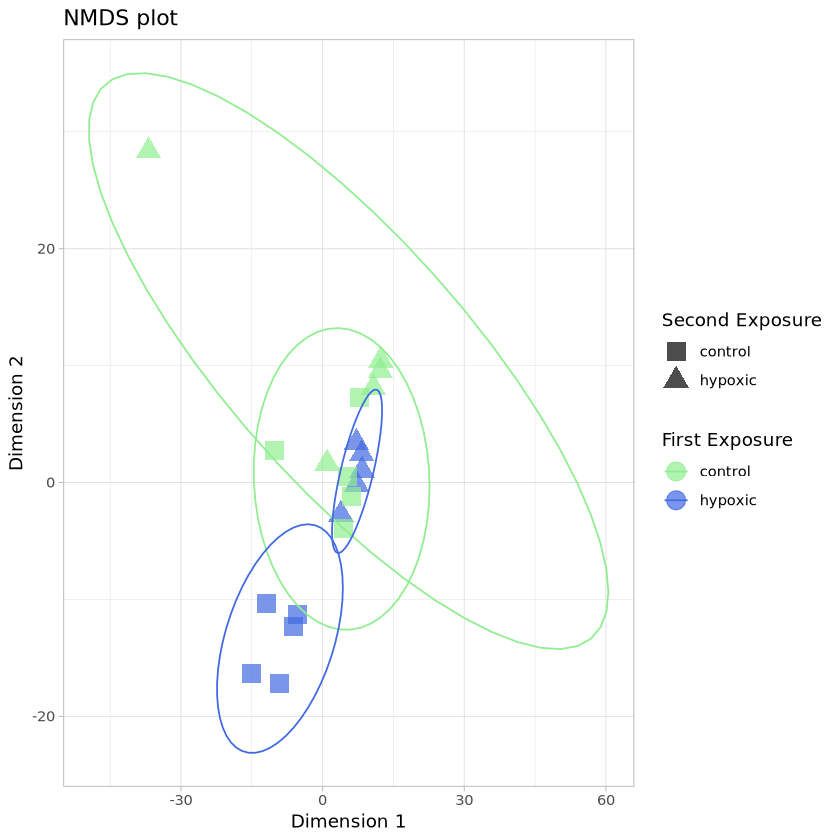

In [31]:
# plot
nmds_plot <- ggplot(mds, aes(X1, X2, shape = Phase2, col = Phase1)) + 
  geom_point(size = 5, alpha = 0.7) +
scale_shape_manual(values = c(15, 17)) +
#coord_cartesian(xlim=c(-30,30), ylim = c(-15,15)) +
scale_color_manual(values = c('lightgreen','royalblue')) +
labs(title = "NMDS plot", x = "Dimension 1", y = "Dimension 2", color = "First Exposure", shape = "Second Exposure") +
stat_ellipse() +
theme_light()

nmds_plot

could also display so each unique set of treatments are their own color, and have the colors make a little sense (more neutral for CC, more vibrant for HH) following what I've done for the genomic feature figures to keep things consistent

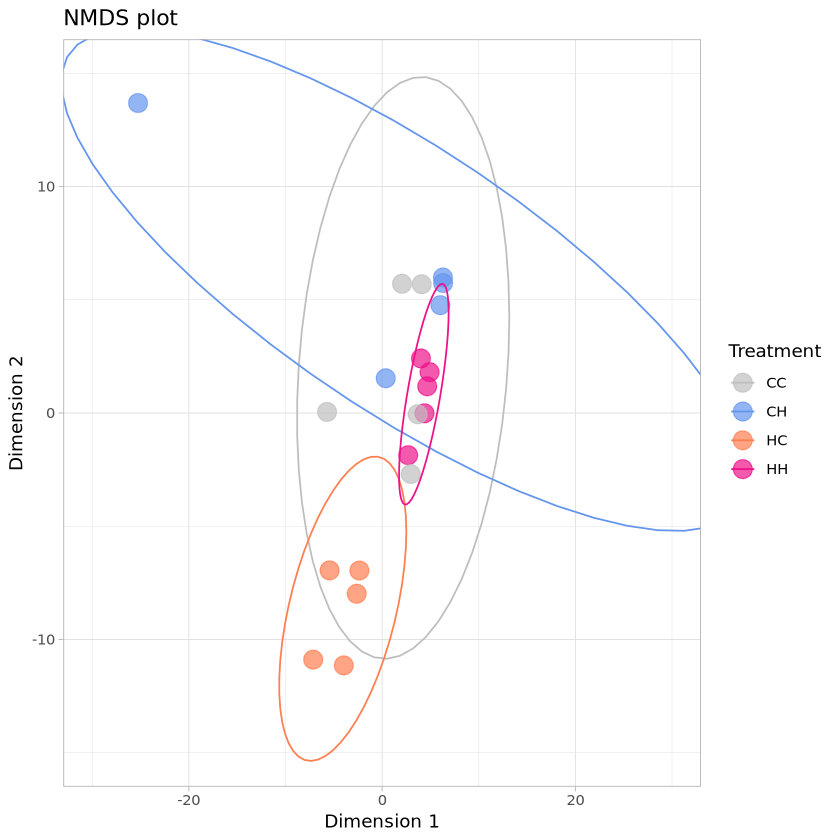

In [15]:
# plot
nmds_plot <- ggplot(mds, aes(X1, X2, col = trmt)) + 
  geom_point(size = 5, alpha = 0.7) +
scale_shape_manual(values = c(15, 17)) +
coord_cartesian(xlim=c(-30,30), ylim = c(-15,15)) +
scale_color_manual(values=c('gray', 'cornflowerblue', 'coral','deeppink2')) +
labs(title = "NMDS plot", x = "Dimension 1", y = "Dimension 2", color = "Treatment") +
stat_ellipse() +
theme_light()

nmds_plot

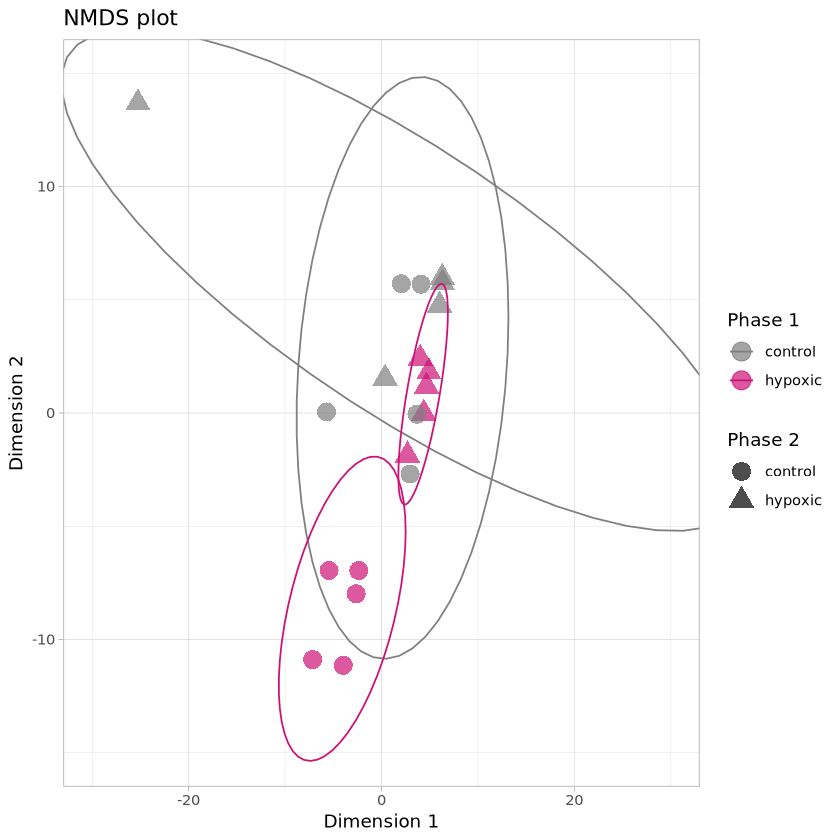

In [25]:
# plot
nmds_plot <- ggplot(mds, aes(X1, X2, col = Phase1, shape = Phase2)) + 
  geom_point(size = 5, alpha = 0.7) +
scale_shape_manual(values = c(16, 17)) +
coord_cartesian(xlim=c(-30,30), ylim = c(-15,15)) +
scale_color_manual(values=c('gray50', 'deeppink3')) +
labs(title = "NMDS plot", x = "Dimension 1", y = "Dimension 2", color = "Phase 1", shape = 'Phase 2') +
stat_ellipse() +
theme_light()

nmds_plot

Dimension 1 explains 12.97 % of variation
Dimension 2 explains 9.82 % of variation


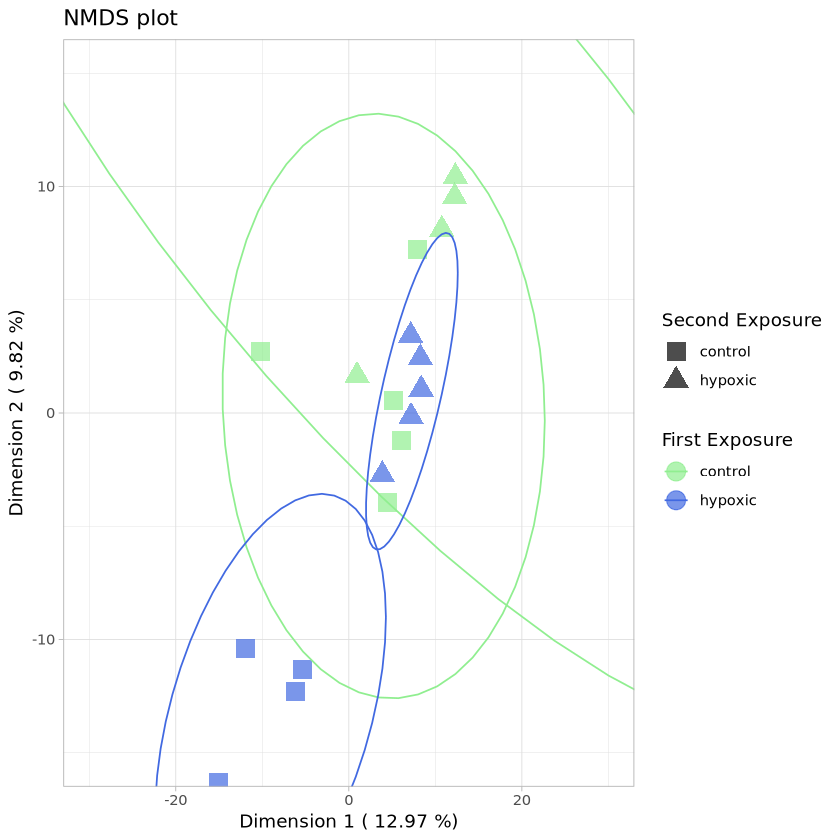

In [32]:
# Calculate eigenvalues
eigenvalues <- cmdscale(sample_dists, k = 2, eig = TRUE)$eig

# Calculate percentage variation explained
variation_explained <- (eigenvalues / sum(eigenvalues)) * 100

# Print results
cat("Dimension 1 explains", round(variation_explained[1], 2), "% of variation\n")
cat("Dimension 2 explains", round(variation_explained[2], 2), "% of variation\n")

# Add labels to plot
nmds_plot <- ggplot(mds, aes(X1, X2, shape = Phase2, col = Phase1)) + 
  geom_point(size = 5, alpha = 0.7) +
  scale_shape_manual(values = c(15, 17)) +
  coord_cartesian(xlim=c(-30,30), ylim = c(-15,15)) +
  scale_color_manual(values = c('lightgreen','royalblue')) +
  labs(title = "NMDS plot", 
       #subtitle = paste("Dimension 1:", round(variation_explained[1], 2), "%, Dimension 2:", round(variation_explained[2], 2), "%"),
       x = paste("Dimension 1 (", round(variation_explained[1], 2), "%)"), 
       y = paste("Dimension 2 (", round(variation_explained[2], 2), "%)"),
       color = "First Exposure", 
       shape = "Second Exposure") +
  stat_ellipse() +
  theme_light()

nmds_plot

In [62]:
ggsave('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/figures/nmds_plot.pdf', nmds_plot)

Saving 6.67 x 6.67 in image


when considering all methylated loci, methylation status explains 23.89% of variation

doing the same NMDS plot but only for genes that were identified as sig. DM in any pairwise comparison

In [33]:
# CC vs. HC
CC_HC <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/CC_vs_HC.csv')
df1 <- filter(CC_HC, padj < 0.05)
rownames(df1) <- df1$X

# CH_HC
CH_HC <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/CH_vs_HC.csv')
df2 <- filter(CH_HC, padj < 0.05)
rownames(df2) <- df2$X

# HH_HC
HH_HC <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/HH_vs_HC.csv')
df3 <- filter(HH_HC, padj < 0.05)
rownames(df3) <- df3$X

# HH_CH
HH_CH <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/HH_vs_CH.csv')
df4 <- filter(HH_CH, padj < 0.05)
rownames(df4) <- df4$X

# HH_CC
HH_CC <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/CC_vs_HH.csv')
df5 <- filter(HH_CC, padj < 0.05)
rownames(df5) <- df5$X

# CC_CH
CC_CH <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/CC_vs_CH.csv')
df6 <- filter(CC_CH, padj < 0.05)
rownames(df6) <- df6$X

# Define the list of dataframes containing DMGs
dmg_dfs <- list(df1, df2, df3, df4, df5, df6)

# Extract unique gene names from all dataframes
all_dmg_genes <- unique(unlist(lapply(dmg_dfs, function(x) rownames(x))))

,X1,X2,Phase1,Phase2,treatment,sizeFactor
,<dbl>,<dbl>,<chr>,<chr>,<fct>,<dbl>
BBB-WBO-B21,-3.827181,-0.5541501,hypoxic,control,hypoxic_control,2.354451
BBB-WBV-B70,-3.085163,-0.3468558,hypoxic,control,hypoxic_control,2.038074
BBO-BBO-B16,1.238775,-0.9894135,hypoxic,hypoxic,hypoxic_hypoxic,1.671849
BBO-BBY-B27,1.280828,-1.0226017,hypoxic,hypoxic,hypoxic_hypoxic,1.113611
BBO-WBO-B16,-3.128118,-0.4936210,hypoxic,control,hypoxic_control,2.422014
BBO-WBV-B64,-3.243235,-0.2936882,hypoxic,control,hypoxic_control,2.146717


Dimension 1 explains 55.54 % of variation
Dimension 2 explains 9.36 % of variation


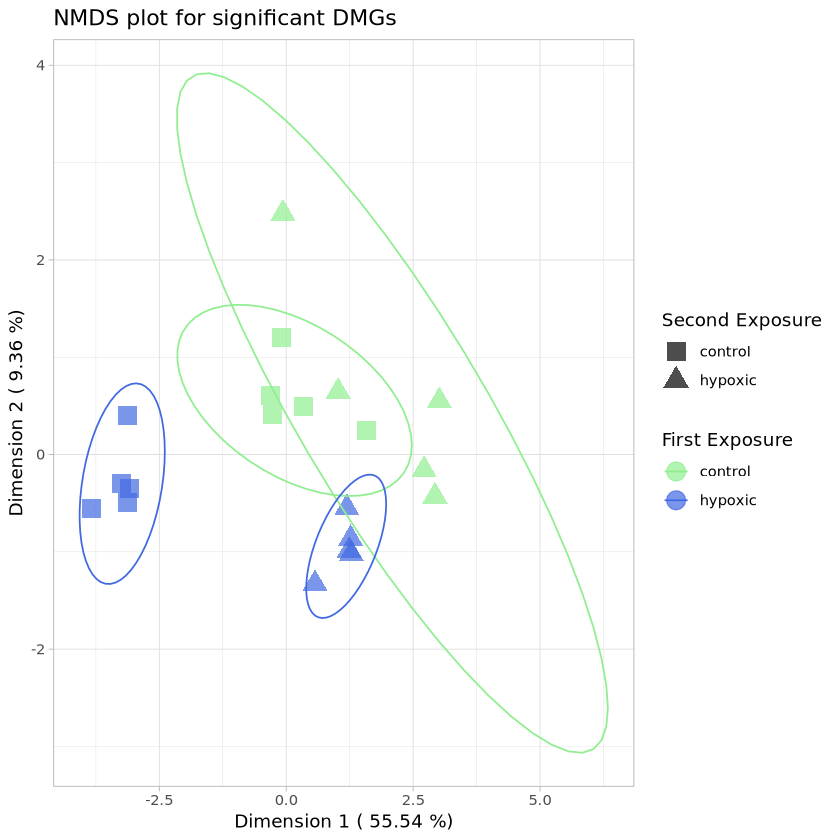

In [57]:
# MDS plot

# normalization & transformation
vsd <- vst(dds)

vsd_sig <- vsd[all_dmg_genes, ]

# calculate sample distances
sample_dists <- assay(vsd_sig) %>%
t() %>%
dist() %>%
as.matrix()

# calculate MDS value from distance matrix
mdsData <- data.frame(cmdscale(sample_dists))
mds <- cbind(mdsData, as.data.frame(colData(vsd_sig))) # combine with sample data
head(mds)

# Calculate eigenvalues
eigenvalues <- cmdscale(sample_dists, k = 2, eig = TRUE)$eig

# Calculate percentage variation explained
variation_explained <- (eigenvalues / sum(eigenvalues)) * 100

# Print results
cat("Dimension 1 explains", round(variation_explained[1], 2), "% of variation\n")
cat("Dimension 2 explains", round(variation_explained[2], 2), "% of variation\n")

# plot
nmds_plot_sigOnly <- ggplot(mds, aes(X1, X2, shape = Phase2, col = Phase1)) + 
  geom_point(size = 5, alpha = 0.7) +
scale_shape_manual(values = c(15, 17)) +
#coord_cartesian(xlim=c(-20,20), ylim = c(-15,15)) +
scale_color_manual(values = c('lightgreen','royalblue')) +
labs(title = "NMDS plot for significant DMGs", 
     x = paste("Dimension 1 (", round(variation_explained[1], 2), "%)"), 
       y = paste("Dimension 2 (", round(variation_explained[2], 2), "%)"),
     color = "First Exposure", 
     shape = "Second Exposure") +
stat_ellipse() +
theme_light()

nmds_plot_sigOnly

In [58]:
ggsave('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/figures/nmds_plot_sigOnly.pdf', nmds_plot_sigOnly)

Saving 6.67 x 6.67 in image


In [ ]:
write.csv(mds, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/nmds_input_sigOnly.csv')

when considering only genes that are significantly differentially methylated in any pairwise comparison, methylation status explains 61.61% of the variation

#### NMDS but blind=FALSE

In [32]:
# MDS plot

# normalization & transformation
vsd <- vst(dds, blind=FALSE)

# calculate sample distances
sample_dists <- assay(vsd) %>%
t() %>%
dist() %>%
as.matrix()

head(sample_dists)

# calculate MDS value from distance matrix
mdsData <- data.frame(cmdscale(sample_dists))
mds <- cbind(mdsData, as.data.frame(colData(vsd))) # combine with sample data
head(mds)

,BBB-WBO-B21,BBB-WBV-B70,BBO-BBO-B16,BBO-BBY-B27,BBO-WBO-B16,BBO-WBV-B64,BBR-BBB-B50,BBR-BBG-B38,BBR-BBY-B26,BBY-WBG-B42,WBB-WBV-W69,WBG-BBB-W56,WBG-WBG-W44,WBO-BBR-W03,WBO-WBV-W64,WBR-BBY-W25,WBV-WBO-W23,WBV-WBR-W12,WBY-BBV-W65,WBY-BBY-W30
BBB-WBO-B21,0.00000,25.10087,27.80075,28.14706,24.67255,24.44660,27.69713,26.08967,27.05063,25.76316,26.51677,29.79374,30.84970,34.30517,27.13488,30.27137,29.85958,33.33264,30.16573,29.41943
BBB-WBV-B70,25.10087,0.00000,25.32803,27.08699,24.89514,24.68098,24.98566,25.84769,25.79278,29.26647,26.27759,28.73826,30.62144,35.57319,26.34015,26.76258,29.12640,33.57755,29.60366,28.10786
BBO-BBO-B16,27.80075,25.32803,0.00000,25.11257,25.26564,27.49349,23.67393,23.87681,22.93442,29.58033,26.01359,25.15136,27.75386,36.13267,25.16196,26.46339,26.89641,30.48996,25.07149,24.71046
BBO-BBY-B27,28.14706,27.08699,25.11257,0.00000,27.15381,26.66499,25.41825,25.12582,22.49844,30.55504,26.80567,26.51423,28.90994,36.13882,26.49802,29.25314,28.65605,31.60619,25.61024,23.68299
BBO-WBO-B16,24.67255,24.89514,25.26564,27.15381,0.00000,24.95891,26.23452,26.22608,25.54389,28.12540,25.58826,28.38423,29.89653,35.36404,25.53630,29.09567,28.44653,31.54923,27.66843,27.85821
BBO-WBV-B64,24.44660,24.68098,27.49349,26.66499,24.95891,0.00000,27.39473,26.68749,25.14861,28.42690,24.11720,28.66706,29.57063,34.31145,26.46352,29.37937,29.83702,32.78724,29.50352,28.03145


,X1,X2,Phase1,Phase2,treatment,sizeFactor
,<dbl>,<dbl>,<chr>,<chr>,<fct>,<dbl>
BBB-WBO-B21,-7.094168,-10.813563,hypoxic,control,hypoxic_control,2.354451
BBB-WBV-B70,-2.614877,-7.923279,hypoxic,control,hypoxic_control,2.038074
BBO-BBO-B16,4.635658,1.171299,hypoxic,hypoxic,hypoxic_hypoxic,1.671849
BBO-BBY-B27,3.990057,2.390508,hypoxic,hypoxic,hypoxic_hypoxic,1.113611
BBO-WBO-B16,-2.337264,-6.908168,hypoxic,control,hypoxic_control,2.422014
BBO-WBV-B64,-5.409997,-6.901702,hypoxic,control,hypoxic_control,2.146717


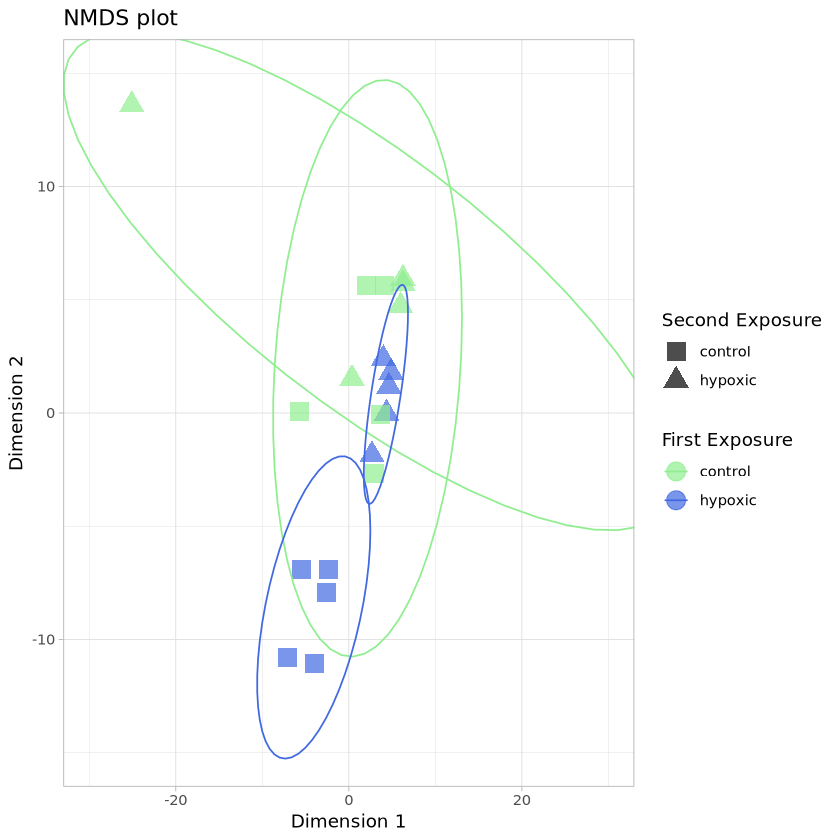

In [33]:
# plot
ggplot(mds, aes(X1, X2, shape = Phase2, col = Phase1)) + 
  geom_point(size = 5, alpha = 0.7) +
scale_shape_manual(values = c(15, 17)) +
coord_cartesian(xlim=c(-30,30), ylim = c(-15,15)) +
scale_color_manual(values = c('lightgreen','royalblue')) +
labs(title = "NMDS plot", x = "Dimension 1", y = "Dimension 2", color = "First Exposure", shape = "Second Exposure") +
stat_ellipse() +
theme_light()

still looks the same so not a huge deal

## Heatmap

In [ ]:
vsd <- vst(dds)

In [ ]:
library(pheatmap)

In [ ]:
ntd <- normTransform(dds)

In [ ]:
# Define the list of dataframes containing DMGs
dmg_dfs <- list(df1, df2, df3, df4, df5, df6)

# Extract unique gene names from all dataframes
all_dmg_genes <- unique(unlist(lapply(dmg_dfs, function(x) rownames(x))))

# Filter counts for significant genes
sig_counts <- counts(dds, normalized=TRUE)[all_dmg_genes, ]

# Select top 20 significant genes by row mean
select_sig <- order(rowMeans(sig_counts), decreasing=TRUE)[1:20]

# Create annotation data frame
df <- as.data.frame(colData(dds)[,c("Phase2", "Phase1")])
colnames(df) <- c("Phase 2", "Phase 1")

# Define color palette
phase1_colors <- c("control" = "white", "hypoxic" = "black")
phase2_colors <- c("control" = "white", "hypoxic" = "black")

# Create heatmap
pheatmap(assay(dds)[all_dmg_genes[select_sig], ], 
         cluster_rows=FALSE, show_rownames=TRUE,
         cluster_cols=TRUE, 
         annotation_col=df,
         annotation_colors= list('Phase 1'=phase1_colors, 'Phase 2'=phase2_colors),
         main="Significant Genes Heatmap")

^ selected top 20 genes by row mean

In [ ]:
# Define the list of dataframes containing DMGs
dmg_dfs <- list(df1, df2, df3, df4, df5, df6)

# Extract unique gene names from all dataframes
all_dmg_genes <- unique(unlist(lapply(dmg_dfs, function(x) rownames(x))))

# Filter counts for significant genes
sig_counts <- counts(dds, normalized=TRUE)[all_dmg_genes, ]

# Calculate row-wise standard deviation
std_dev <- apply(sig_counts, 1, sd)

# Select top 20 genes by standard deviation
select_sig <- order(std_dev, decreasing=TRUE)[1:20]

# Create annotation data frame
df <- as.data.frame(colData(dds)[,c("Phase2", "Phase1")])
colnames(df) <- c("Phase 2", "Phase 1")

# Define color palette
phase1_colors <- c("control" = "white", "hypoxic" = "black")
phase2_colors <- c("control" = "white", "hypoxic" = "black")

# Create heatmap
pheatmap(assay(dds)[all_dmg_genes[select_sig], ], 
         cluster_rows=FALSE, show_rownames=TRUE,
         cluster_cols=TRUE, 
         annotation_col=df,
         annotation_colors= list('Phase 1'=phase1_colors, 'Phase 2'=phase2_colors),
         main="Significant Genes Heatmap")

^ selected top 20 genes with highest row-wise standard deviation

## Overlap of sig DMGs with previous method

in the previous method, I was only counting methylation in exons for meta-features (genes) - since realizing, I now have methylation happening anywhere in the gene region included. My results are still similar and showing the same general pattern, but would now like to see how much has remained the same for sig. DMGs

In [ ]:
# pulling out sig DMGs for pairwise comparisons against HC (hypoxic control)

# OG = original DMGs
OG_sig_HH <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/sig_DMGs_gene_names/sig_HH_HC_genes.csv')
OG_sig_CH <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/sig_DMGs_gene_names/sig_CH_HC_genes.csv')
OG_sig_CC <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/sig_DMGs_gene_names/sig_CC_HC_genes.csv')

# new DMGs
new_sig_HH <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/sig_DMGs/sig_HH_HC_genes.csv')
new_sig_CH <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/sig_DMGs/sig_CH_HC_genes.csv')
new_sig_CC <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/sig_DMGs/sig_CC_HC_genes.csv')

In [ ]:
# combining OG dmgs into one dataframe

OG_sig_HH$pair <- 'HH_HC'
OG_sig_CH$pair <- 'CH_HC'
OG_sig_CC$pair <- 'CC_HC'

OG_dmg <- rbind(OG_sig_HH, OG_sig_CH, OG_sig_CC)
head(OG_dmg)

In [ ]:
# combining new dmgs into one dataframe
new_sig_HH$pair <- 'HH_HC'
new_sig_CH$pair <- 'CH_HC'
new_sig_CC$pair <- 'CC_HC'

new_dmg <- rbind(new_sig_HH, new_sig_CH, new_sig_CC)
head(new_dmg)

looking at overlap of new and OG dmgs **overall**

In [ ]:
library(ggvenn)

In [ ]:
x = list(A = new_dmg$symbol,
         B = OG_dmg$symbol)

names(x) <- c('new DMGs',
             'original DMGs')

# same colors as used in the volcano plots
#custom_colors <- c('#F8766D',  '#7CAE00', )

#png(filename="/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/venn_genes/venn_diagram.png")


ggvenn(x,
      set_name_size = 6,
       text_size = 7,
      stroke_size = 0.5, 
       show_percentage = TRUE)


in total, 141 sig DMGs that were originally identified are still significantly DMG in the new analysis, with an additional 76 genes that were not previously identified


looking by pairwise comparison


### hypoxic hypoxic vs. hypoxic control

In [ ]:
x = list(A = new_sig_HH$symbol,
         B = OG_sig_HH$symbol)

names(x) <- c('new DMGs',
              'original DMGs')


ggvenn(x,
      set_name_size = 6,
       text_size = 7,
      stroke_size = 0.5, 
       show_percentage = TRUE)

51 sig. DMGs remain the same in this comparison, but 25 new sig DMGs have been identified with the new analysis 

### control hypoxic vs. hypoxic control

In [ ]:
x = list(A = new_sig_CH$symbol,
         B = OG_sig_CH$symbol)

names(x) <- c('new DMGs',
              'original DMGs')


ggvenn(x,
      set_name_size = 6,
       text_size = 7,
      stroke_size = 0.5, 
       show_percentage = TRUE)

122 significantly differentially methylated genes remained the same for both analyses, but there are 71 that weren't originally identified in the OG analysis

### control control vs. hypoxic control

In [ ]:
x = list(A = new_sig_CC$symbol,
         B = OG_sig_CC$symbol)

names(x) <- c('new DMGs',
              'original DMGs')


ggvenn(x,
      set_name_size = 6,
       text_size = 7,
      stroke_size = 0.5, 
       show_percentage = TRUE)

so nothing changed for the differentially methylated genes found in the pairwise comparison of control control vs. hypoxic control

In [ ]:
write.csv(new_dmg, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/sig_DMGs/all_sig_DMGs.csv')

In [ ]:
head(new_sig_HH)
head(new_sig_CH)
head(new_sig_CC)

In [ ]:
all_shared_DMG <- merge(merge(new_sig_HH, new_sig_CH, by = "symbol"), new_sig_CC, by = "symbol")
head(all_shared_DMG)